In [1]:
import healpy as hp
import numpy as np
from rubin_scheduler.utils import (
    angular_separation,
    ddf_locations,
    ddf_locations_pre3_5,
    hpid2_ra_dec,
    sample_patch_on_sphere,
    calc_season
)

import rubin_sim.maf as maf
import sqlite3
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
file_name = "baseline_v4.2_10yrs.db"
run_name = file_name.replace(".db", "")
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [3]:
nside=512
radius=2.5
nside_sne=128

In [4]:

ddfs = {}
ddfs_rough = ddf_locations()
for ddf in ddfs_rough:
    if "COSM" in ddf:
        ddfs[ddf] = {"ra": ddfs_rough[ddf][0], "dec": ddfs_rough[ddf][1]}

In [5]:
ddfs

{'COSMOS': {'ra': 150.1083333333333, 'dec': 2.233611111111111}}

In [6]:
con = sqlite3.connect(file_name)
df = pd.read_sql_query("select observationStartMJD,night from observations;", con)
con.close()

mjd = df["observationStartMJD"].values
night = df["night"].values

In [7]:
df

,observationStartMJD,night
0,60980.001582,0
1,60980.001822,0
2,60980.002063,0
3,60980.002302,0
4,60980.002542,0
...,...,...
1997417,64632.271322,3652
1997418,64632.271771,3652
1997419,64632.272219,3652
1997420,64632.272667,3652


In [8]:
seasons = calc_season(ddfs["COSMOS"]["ra"], mjd, mjd_start=mjd.min())

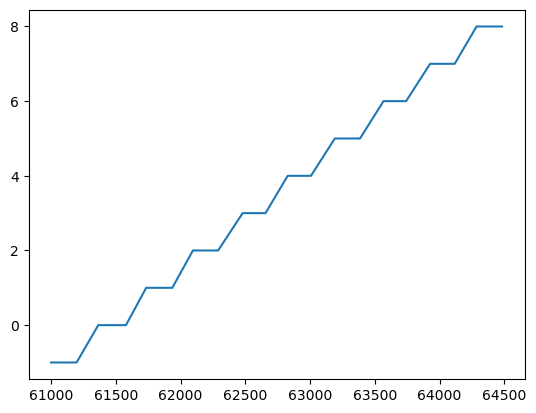

In [9]:
con = sqlite3.connect(file_name)
df = pd.read_sql_query("select observationStartMJD,night from observations where scheduler_note like '%%COSMOS%%';", con)
con.close()
mjd_temp = df["observationStartMJD"].values
seasons_temp = calc_season(ddfs["COSMOS"]["ra"], mjd_temp, mjd_start=mjd_temp.min())

plt.plot(mjd_temp, np.floor(seasons_temp))

In [10]:
ddf_slicers = {}
ddf_slicers_sne = {}
ra, dec = hpid2_ra_dec(nside, np.arange(hp.nside2npix(nside)))
ra_sne, dec_sne = hpid2_ra_dec(nside_sne, np.arange(hp.nside2npix(nside_sne)))
for ddf in ddfs:
    # Define the healpixels to use for this DDF
    if np.size(ddfs[ddf]["ra"]) > 1:
        goods = []
        goods_sne = []
        for ddf_ra, ddf_dec in zip(ddfs[ddf]["ra"], ddfs[ddf]["dec"]):
            dist = angular_separation(ra, dec, ddf_ra, ddf_dec)
            goods.append(np.where(dist <= radius)[0])
            dist = angular_separation(ra_sne, dec_sne, ddf_ra, ddf_dec)
            goods_sne.append(np.where(dist <= radius)[0])
        good = np.unique(np.concatenate(goods))
        good_sne = np.unique(np.concatenate(goods_sne))
    else:
        dist = angular_separation(ra, dec, np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]))
        good = np.where(dist <= radius)[0]
        dist = angular_separation(ra_sne, dec_sne, np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]))
        good_sne = np.where(dist <= radius)[0]
    ddf_slicers_sne[ddf] = maf.HealpixSubsetSlicer(nside_sne, good_sne, use_cache=False)
    ddf_slicers[ddf] = maf.HealpixSubsetSlicer(nside, good, use_cache=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [11]:
plotFuncs = [maf.HealpixSkyMap()]

In [12]:
summary_stats = [maf.MeanMetric(), maf.MedianMetric(), maf.SumMetric()]
bundle_list = []
season_bounds = np.arange(-1,11)

for ddf in ddfs:
    for limit1, limit2 in zip(season_bounds[0:-1], season_bounds[1:]):
        indx = np.where((seasons > limit1) & (seasons < limit2))[0]

        night_min = night[indx].min()
        night_max = night[indx].max()
        
        fieldname = ddf
        plotDict = {
                "visufunc": hp.gnomview,
                "rot": (np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]), 0),
                "xsize": 500,
            }
        metric = maf.metrics.SNNSNMetric(
                    verbose=False,
                    n_bef=4,
                    n_aft=10,
                    zmin=0.1,
                    zmax=1.1,
                    z_step=0.03,
                    daymax_step=3,
                    coadd_night=True,
                    gamma_name="gamma_DDF.hdf5",
                    # have to add field name here, to avoid reduceDict key collissions
                    metric_name=f"SNNSNMetric {fieldname} {limit1}",
                )
        bundle_list.append(
            maf.MetricBundle(
                metric,
                ddf_slicers_sne[ddf],
                constraint="night <= %i and night >= %i" % (night_max, night_min),
                info_label=" ".join([fieldname, "all bands, only DDF observations, season %i" % limit1]),
                plot_dict=plotDict,
                plot_funcs=plotFuncs,
                summary_metrics=summary_stats,
            )
        )
    if True:
        metric = maf.metrics.SNNSNMetric(
                    verbose=False,
                    n_bef=4,
                    n_aft=10,
                    zmin=0.1,
                    zmax=1.1,
                    z_step=0.03,
                    daymax_step=3,
                    coadd_night=True,
                    gamma_name="gamma_DDF.hdf5",
                    # have to add field name here, to avoid reduceDict key collissions
                    metric_name=f"SNNSNMetric {fieldname}",
                )
        bundle_list.append(
            maf.MetricBundle(
                metric,
                ddf_slicers_sne[ddf],
                constraint="",
                info_label=" ".join([fieldname, "all bands, only DDF observations"]),
                plot_dict=plotDict,
                plot_funcs=plotFuncs,
                summary_metrics=summary_stats,
            )
        )

Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 63121 799 79
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 73508 799 92
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 88689 799 111


In [13]:
for b in bundle_list:
    b.set_run_name(run_name)
bundleDict = maf.make_bundles_dict_from_list(bundle_list)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:688: UserWarning: MetricBundle (baseline_v4_2_10yrs_SNNSNMetric_COSMOS_9_reducen_

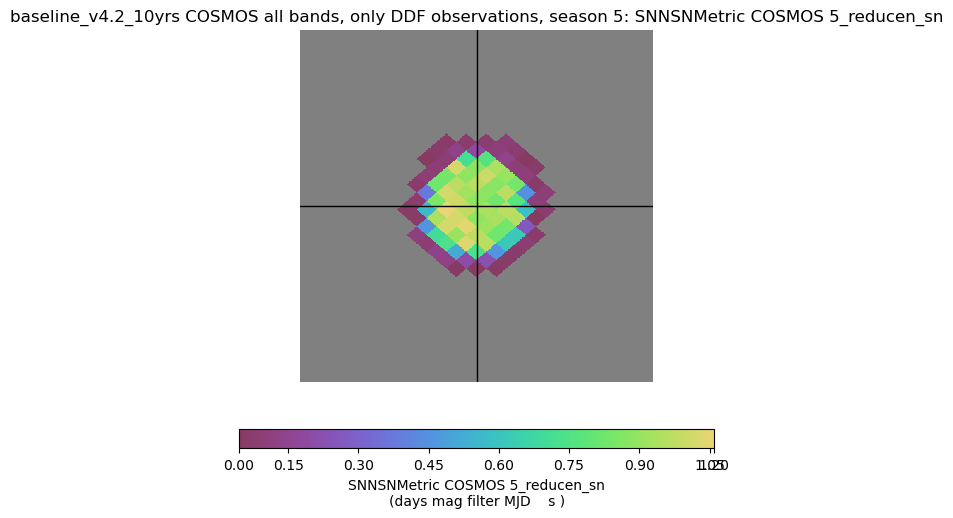

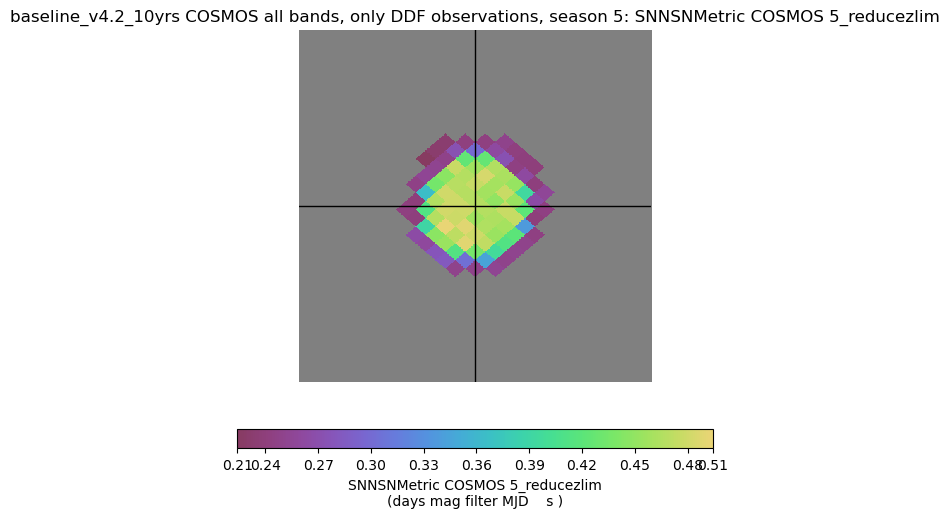

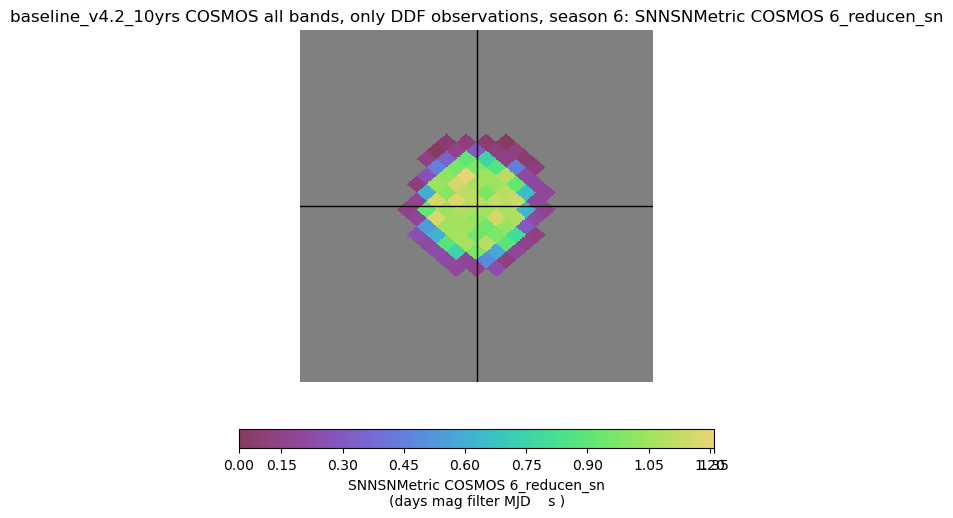

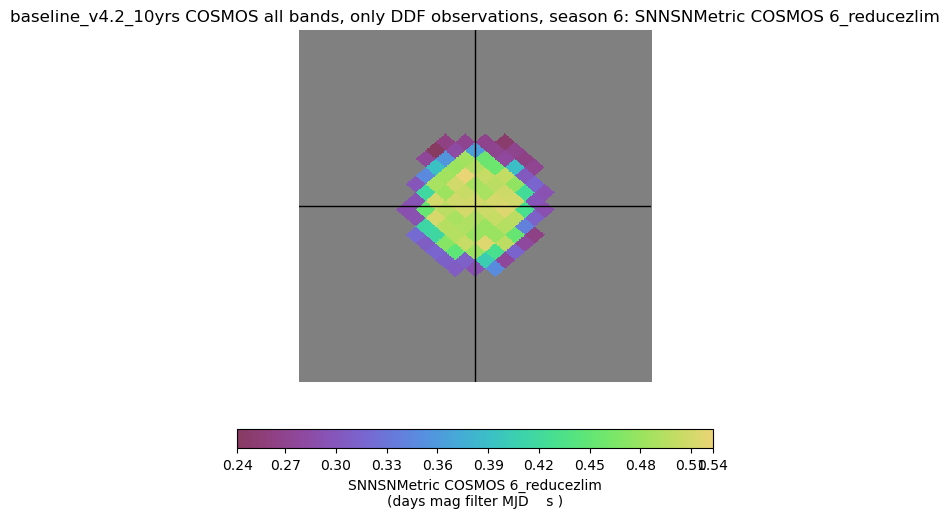

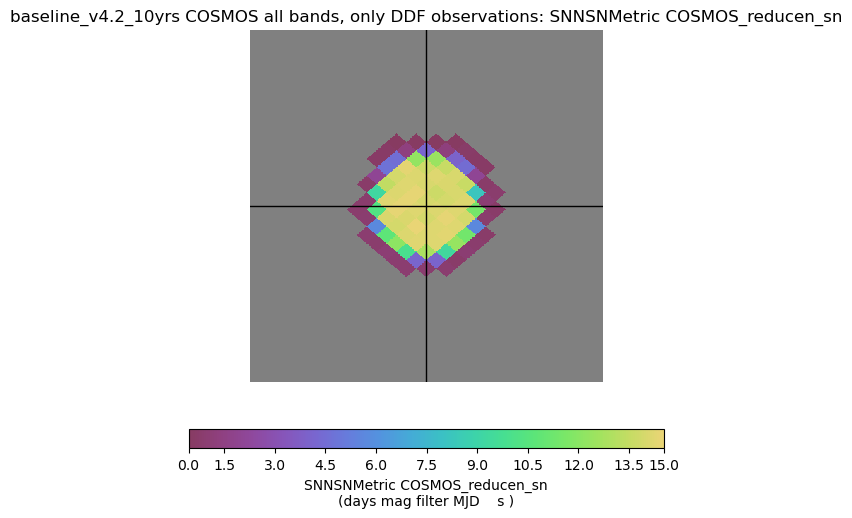

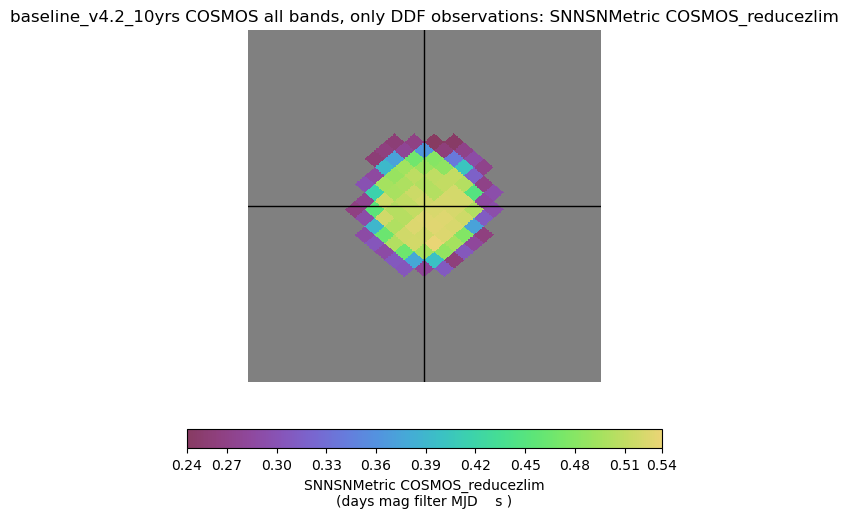

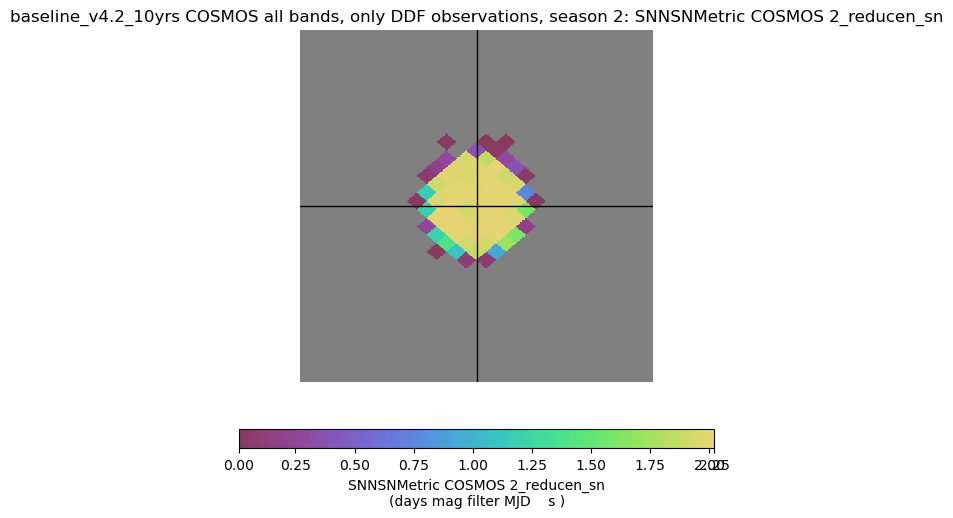

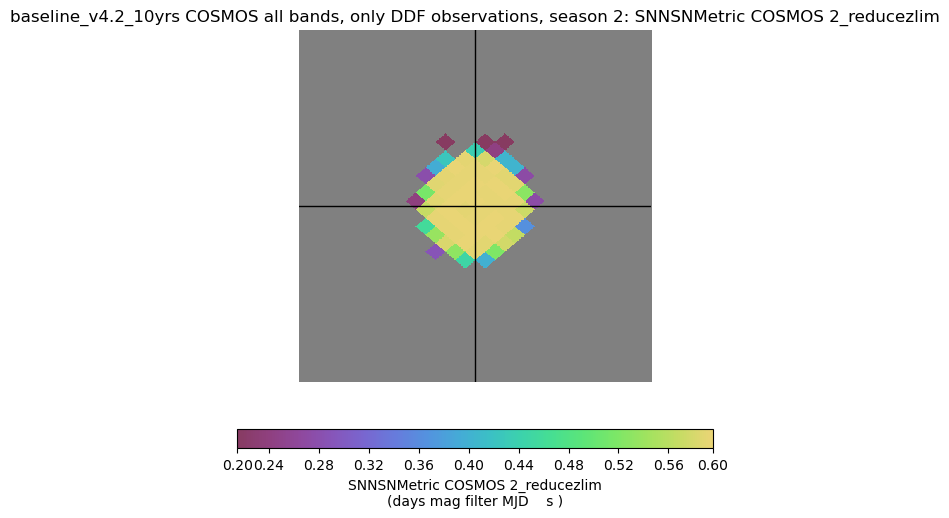

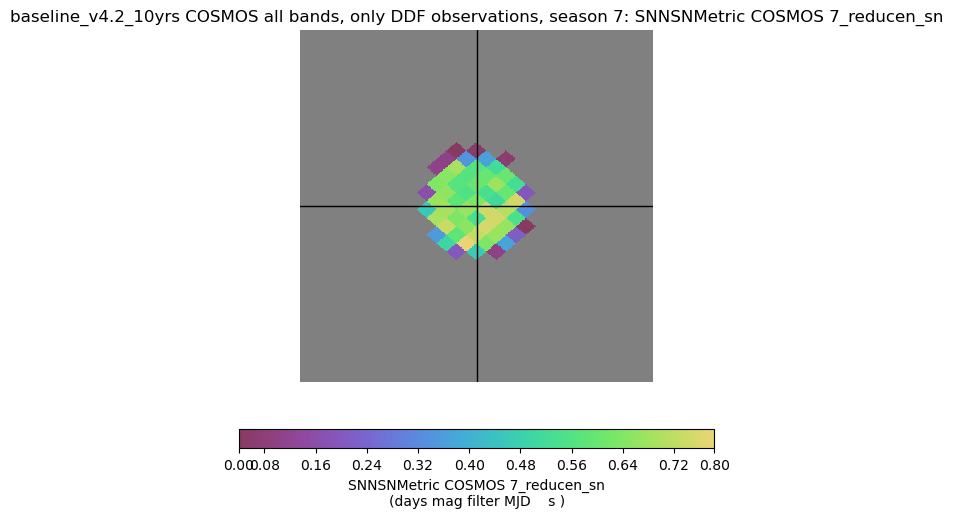

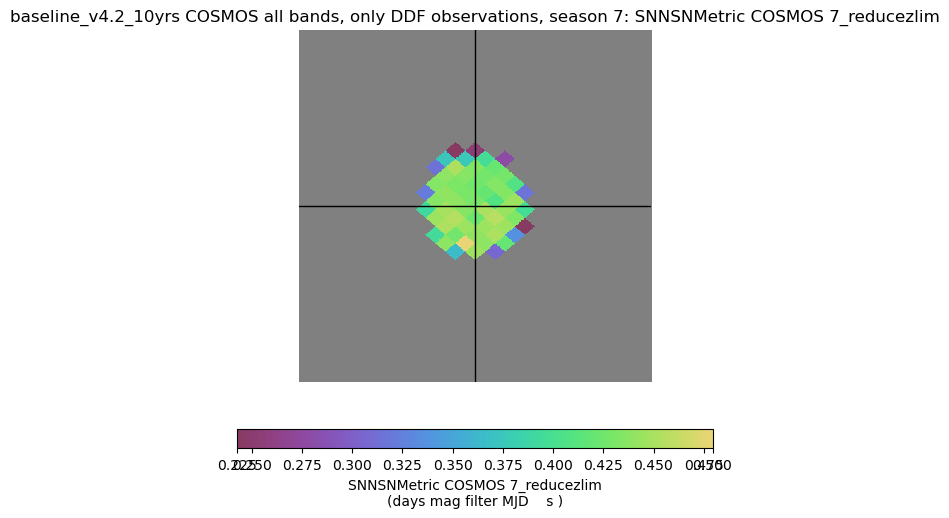

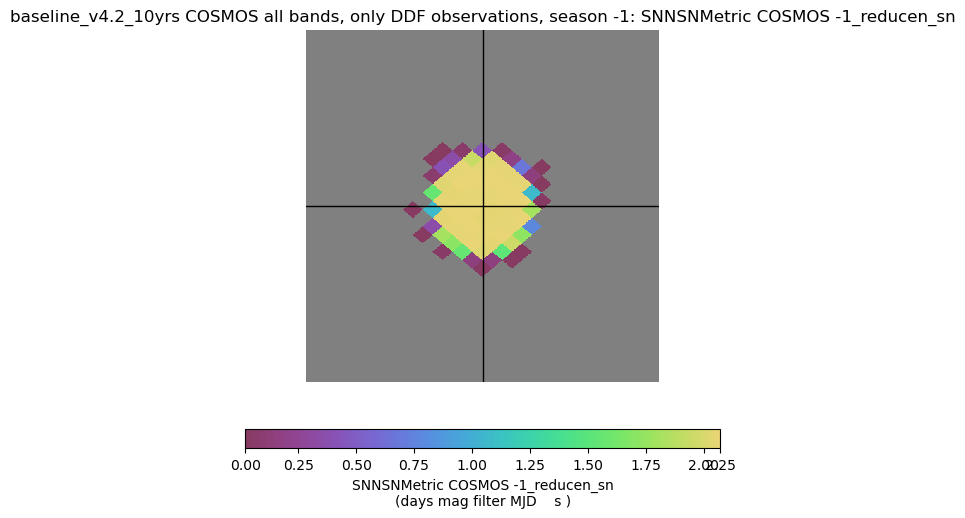

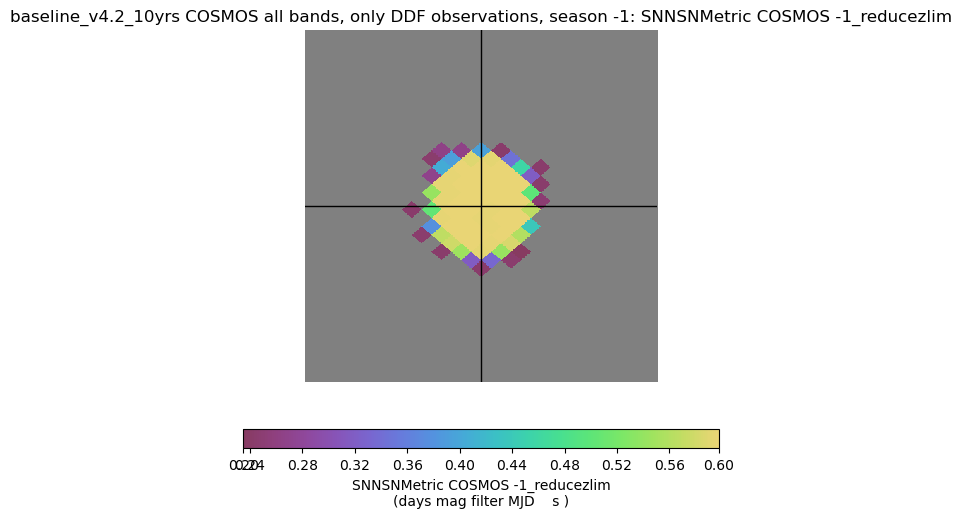

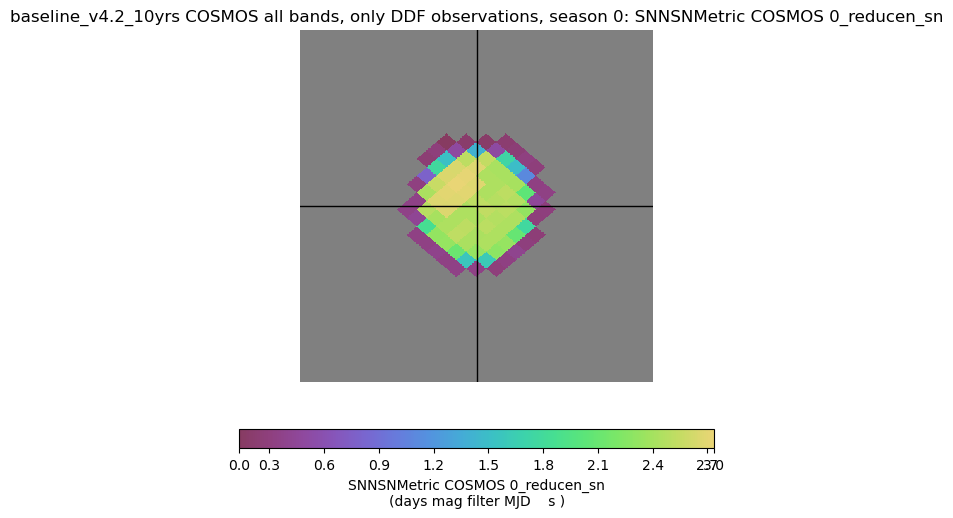

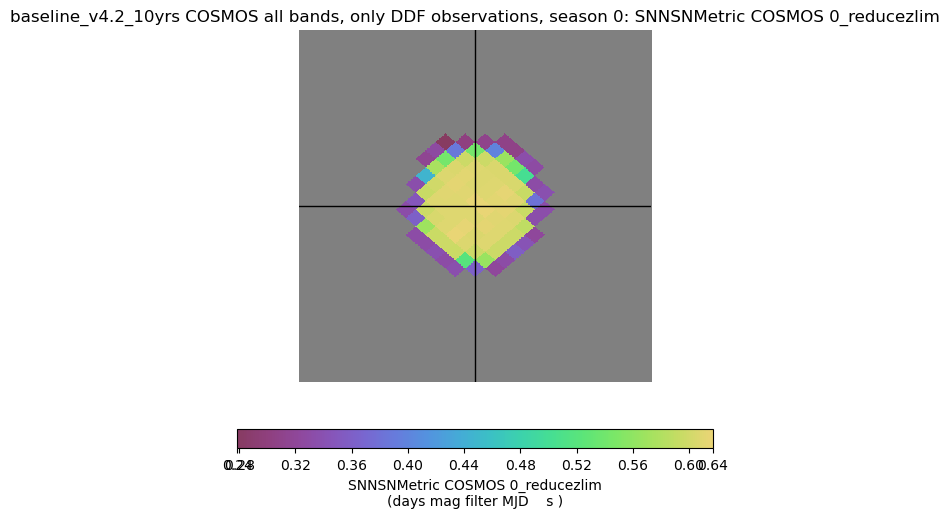

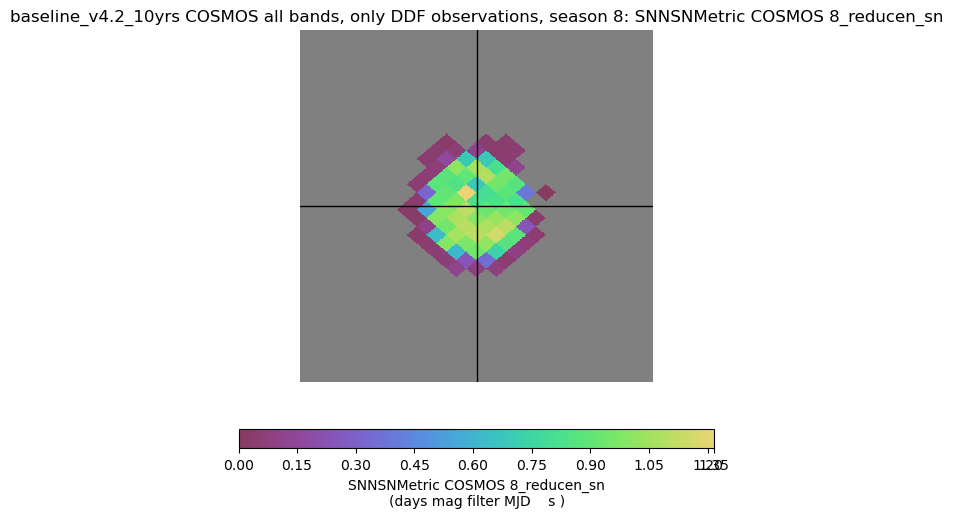

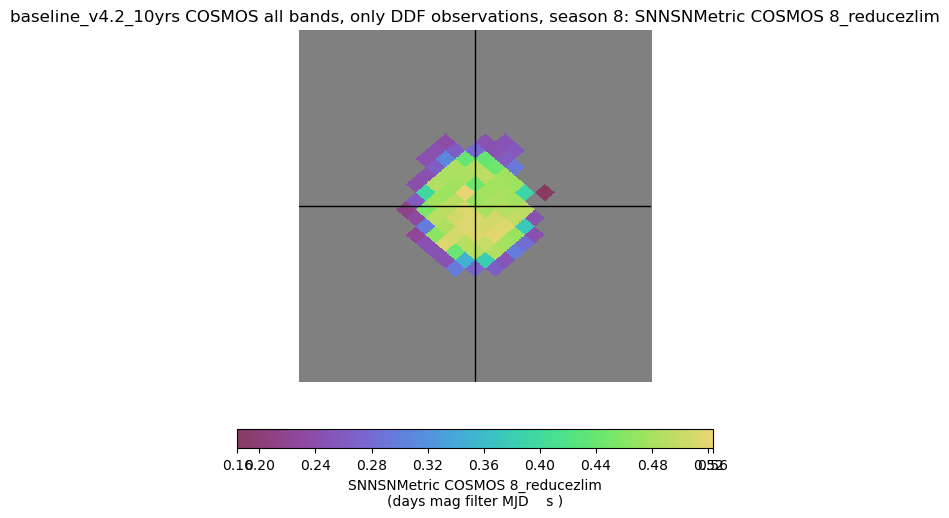

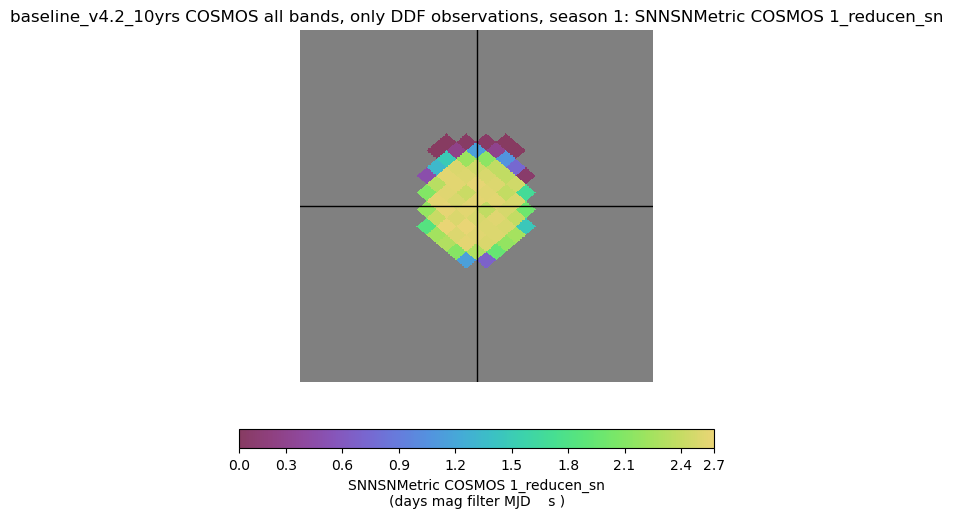

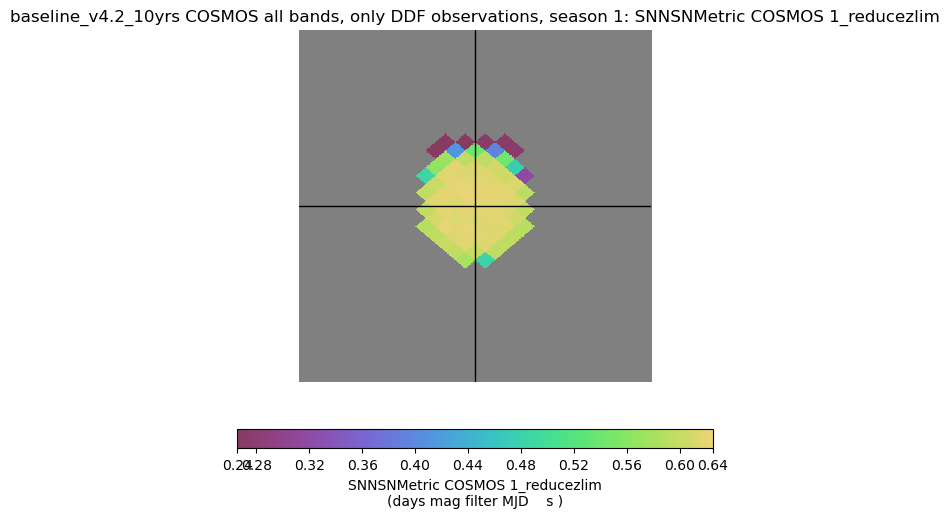

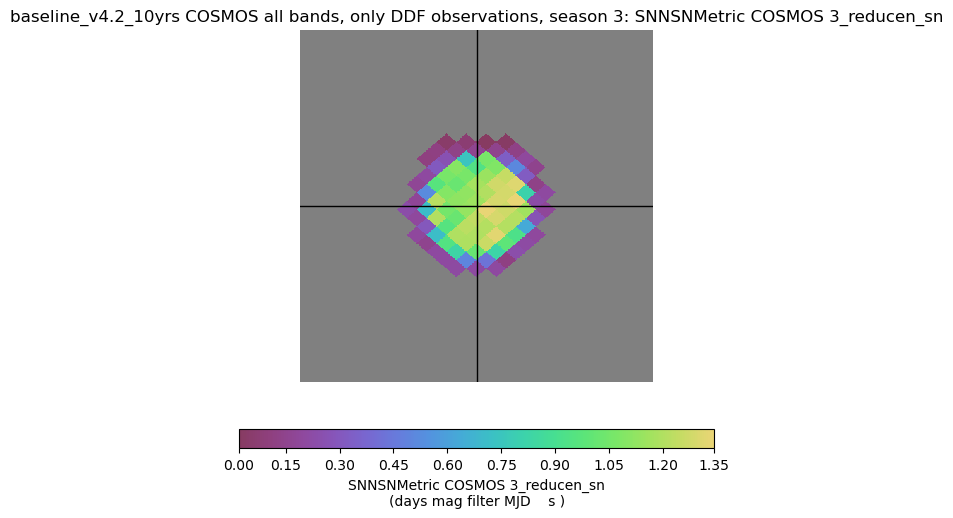

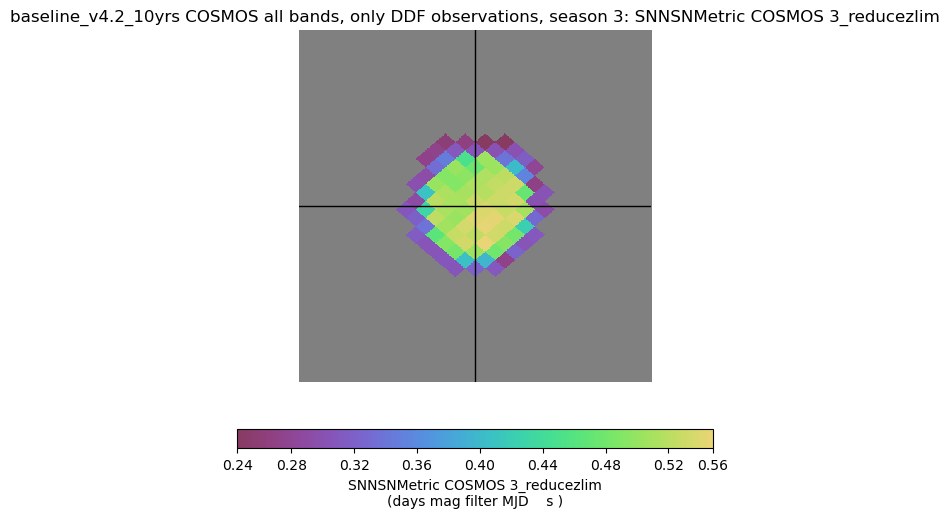

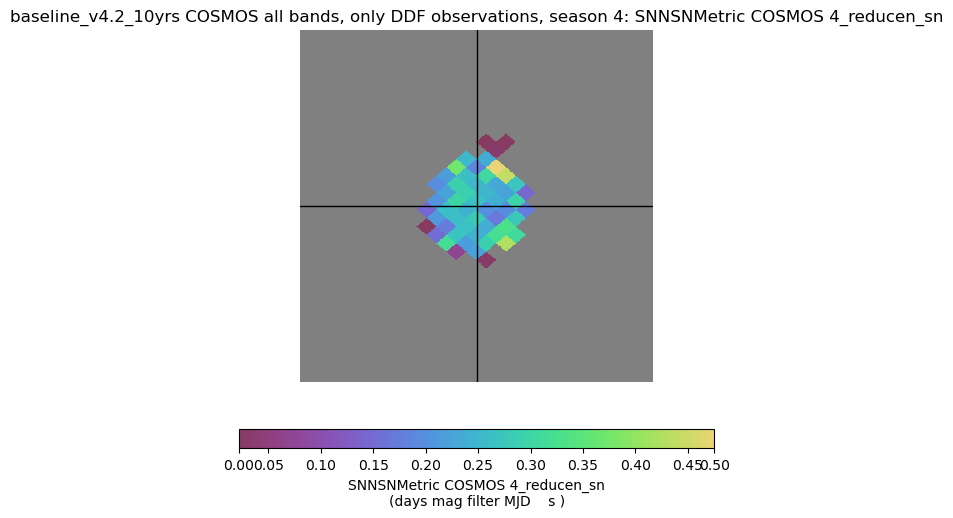

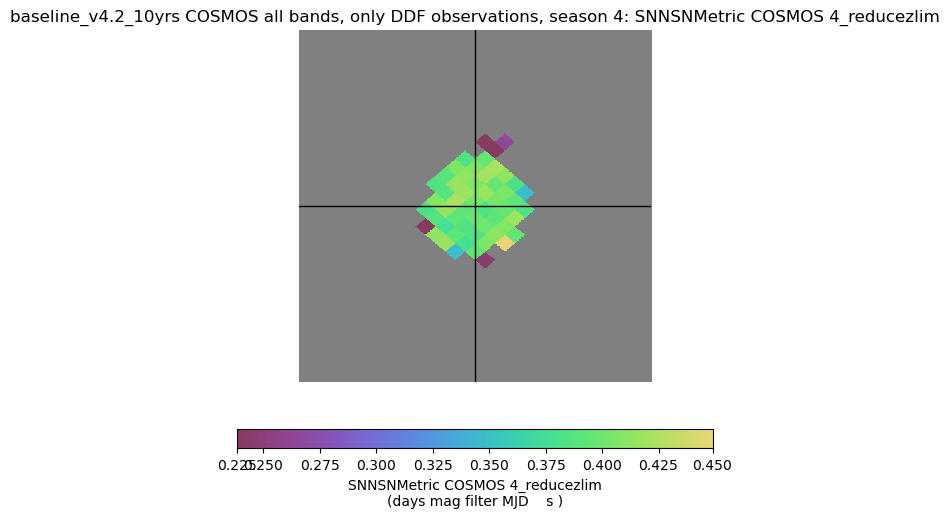

In [14]:
bg = maf.metricBundles.MetricBundleGroup(bundleDict, file_name, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)


In [15]:
for key in bundleDict:
    print(key, bundleDict[key].summary_values)

baseline_v4_2_10yrs_SNNSNMetric_COSMOS_-1_COSMOS_all_bands_only_DDF_observations_season_-1_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_0_COSMOS_all_bands_only_DDF_observations_season_0_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_1_COSMOS_all_bands_only_DDF_observations_season_1_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_2_COSMOS_all_bands_only_DDF_observations_season_2_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_3_COSMOS_all_bands_only_DDF_observations_season_3_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_4_COSMOS_all_bands_only_DDF_observations_season_4_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_5_COSMOS_all_bands_only_DDF_observations_season_5_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_6_COSMOS_all_bands_only_DDF_observations_season_6_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_7_COSMOS_all_bands_only_DDF_observations_season_7_HEAL {}
baseline_v4_2_10yrs_SNNSNMetric_COSMOS_8_COSMOS_all_bands_only_DDF_observations_season_8_HEAL {}
baseline_v4_2_10yrs_SNNSNMet

In [16]:
bundle_list[-1].metric.name


'SNNSNMetric COSMOS'

In [18]:
for key in bundleDict:
    if "zlim" in key:
        print(key, bundleDict[key].summary_values["Median"])

SNNSNMetric COSMOS 5_reducezlim 0.4140795
SNNSNMetric COSMOS 6_reducezlim 0.4390285
SNNSNMetric COSMOS_reducezlim 0.46704650000000003
SNNSNMetric COSMOS 9_reducezlim nan
SNNSNMetric COSMOS 2_reducezlim 0.591151
SNNSNMetric COSMOS 7_reducezlim 0.432797
SNNSNMetric COSMOS -1_reducezlim 0.5953865
SNNSNMetric COSMOS 0_reducezlim 0.5967525
SNNSNMetric COSMOS 8_reducezlim 0.464706
SNNSNMetric COSMOS 1_reducezlim 0.609177
SNNSNMetric COSMOS 3_reducezlim 0.475936
SNNSNMetric COSMOS 4_reducezlim 0.395711


In [19]:
for key in bundleDict:
    if "n_sn" in key:
        print(key, bundleDict[key].summary_values["Sum"])

SNNSNMetric COSMOS 5_reducen_sn 48.71307600000001
SNNSNMetric COSMOS 6_reducen_sn 60.01005199999999
SNNSNMetric COSMOS_reducen_sn 765.55119
SNNSNMetric COSMOS 9_reducen_sn nan
SNNSNMetric COSMOS 2_reducen_sn 98.19052599999999
SNNSNMetric COSMOS 7_reducen_sn 29.457563
SNNSNMetric COSMOS -1_reducen_sn 106.56431000000002
SNNSNMetric COSMOS 0_reducen_sn 155.83090399999995
SNNSNMetric COSMOS 8_reducen_sn 49.960623999999996
SNNSNMetric COSMOS 1_reducen_sn 137.52834199999998
SNNSNMetric COSMOS 3_reducen_sn 66.39573200000001
SNNSNMetric COSMOS 4_reducen_sn 12.900061000000003
